In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fontss-2/LondrinaSketch-Regular.ttf
/kaggle/input/fontss-2/MavenPro-Bold.ttf
/kaggle/input/fontss-2/Jura-Light.ttf
/kaggle/input/fontss-2/MavenPro-Black.ttf
/kaggle/input/fontss-2/CodaCaption-Heavy.ttf
/kaggle/input/fontss-2/JollyLodger-Regular.ttf
/kaggle/input/fontss-2/GreatVibes-Regular.ttf
/kaggle/input/fontss-2/PatrickHand-Regular.ttf
/kaggle/input/fontss-2/NoticiaText-Regular.ttf
/kaggle/input/fontss-2/ChauPhilomeneOne-Regular.ttf
/kaggle/input/fontss-2/ButchermanCaps-Regular.ttf
/kaggle/input/fontss-2/Artifika-Regular.ttf
/kaggle/input/fontss-2/AlmendraSC-Bold.ttf
/kaggle/input/fontss-2/Junge-Regular.ttf
/kaggle/input/fontss-2/MontserratSubrayada-Bold.ttf
/kaggle/input/fontss-2/PassionOne-Black.ttf
/kaggle/input/fontss-2/NanumMyeongjo-Bold.ttf
/kaggle/input/fontss-2/AveriaLibre-Light.ttf
/kaggle/input/fontss-2/Neucha.ttf
/kaggle/input/fontss-2/PTF75F.ttf
/kaggle/input/fontss-2/Ewert-Regular.ttf
/kaggle/input/fontss-2/Alegreya-BlackItalic.ttf
/kaggle/input/fontss-2/

In [2]:
pip install pillow opencv-python numpy nltk matplotlib pandas

Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import random
import numpy as np
import cv2
from PIL import Image, ImageDraw, ImageFont
import nltk
from nltk.corpus import words
from matplotlib import font_manager
import pandas as pd

# Download the NLTK words corpus (if not already downloaded)
nltk.download('words', quiet=True)

# ---------------------------
# Utility functions
# ---------------------------

def get_random_word(min_len=5, max_len=10):
    """
    Returns a random word from the NLTK words corpus that is all alphabetic
    and whose length is between min_len and max_len.
    """
    word_list = [w for w in words.words() if w.isalpha() and min_len <= len(w) <= max_len]
    return random.choice(word_list)

def get_system_fonts():
    """
    Returns a list of system TrueType font file paths using matplotlib's font_manager.
    """
    font_paths = font_manager.findSystemFonts(fontpaths="/kaggle/input/fontss-2", fontext='ttf')
    # If no fonts are found, we will rely on PIL's default font.
    return font_paths if font_paths else []

def random_capitalization(word):
    """
    Returns the word with randomly assigned capitalization for each letter.
    """
    return ''.join(c.upper() if random.random() < 0.5 else c.lower() for c in word)

def create_noisy_background(image_size, background_color=None, sigma=20):
    """Creates a noisy background image with Gaussian noise."""
    # Create a blank image with the desired size
    background = Image.new('RGB', image_size, color=background_color)
    # Add Gaussian noise to the background image
    noisy_background = add_noise_to_image(background, sigma=sigma)
    return noisy_background

def add_noise_to_image(pil_image, sigma=10):
    """
    Adds Gaussian noise to the image using OpenCV.
    """
    image_np = np.array(pil_image)
    # Create Gaussian noise
    noise = np.random.normal(0, sigma, image_np.shape).astype(np.uint8)
    noisy_image = cv2.add(image_np, noise)
    return Image.fromarray(noisy_image)

def generate_text_image(word, font_path, image_size=(128, 64), text_color=None,
                        background_color=None, reverse=False, use_noisy_background=False):
    """
    Generates an image with the given word rendered on it.
    - If reverse is True, the text is drawn in reverse order.
    - If text_color or background_color is None, random colors are chosen.
    - A random font size is also selected.
    """
    padding=10
    # Set default or random colors if not provided.
    if background_color is None:
        # Choose a light background color
        background_color = tuple(random.randint(200, 255) for _ in range(3))
    if text_color is None:
        # Choose a dark text color
        text_color = tuple(random.randint(0, 50) for _ in range(3))

    # Reverse the word if needed.
    display_text = word[::-1] if reverse else word

    # Create a blank image
    if use_noisy_background:
           image = create_noisy_background(image_size, background_color, sigma=20)
    else:
           image = Image.new('RGB', image_size, color=background_color)

    draw = ImageDraw.Draw(image)

    # Determine the maximum font size that will allow the text to fit.
    max_font_size = 40
    min_font_size = 10
    font_size = max_font_size

    # Loop to reduce the font size until the text fits with some padding.
    while font_size >= min_font_size:
       try:
         font = ImageFont.truetype(font_path, font_size)
       except Exception:
         font = ImageFont.load_default()
         break

       text_bbox = draw.textbbox((0, 0), display_text, font=font)  # Get bounding box
       text_width = text_bbox[2] - text_bbox[0]
       text_height = text_bbox[3] - text_bbox[1]

       if text_width <= image_size[0] - padding and text_height <= image_size[1] - padding:
          break

       font_size -= 1

# Ensure a minimum font size
    if font_size < min_font_size:
       font_size = min_font_size
       font = ImageFont.truetype(font_path, font_size)
       text_bbox = draw.textbbox((0, 0), display_text, font=font)
       text_width = text_bbox[2] - text_bbox[0]
       text_height = text_bbox[3] - text_bbox[1]

    # Get text size and compute position for centering
    text_bbox = draw.textbbox((0, 0), display_text, font=font)
    text_width = text_bbox[2] - text_bbox[0]  # width is right - left
    text_height = text_bbox[3] - text_bbox[1] # height is bottom - top
    position = ((image_size[0] - text_width) // 2, (image_size[1] - text_height) // 2)

    # Draw the text onto the image
    draw.text(position, display_text, fill=text_color, font=font)
    return image

# ---------------------------
# Dataset Generation Functions
# ---------------------------

def generate_easy_sample(image_size=(128, 64)):
    """
    Easy Set:
      - Uses a random word (kept in its original capitalization).
      - Uses a fixed plain white background.
      - Uses a randomly selected system font.
    """
    word = get_random_word()
    # For easy set, we fix the background to white and text color to black.
    background_color = (255, 255, 255)
    text_color = (0, 0, 0)
    # fonts = get_system_fonts()
    font_path = "/kaggle/input/fontss/Adamina-Regular.ttf"
    # Use the original word without random capitalization.
    image = generate_text_image(word, font_path, image_size,
                                text_color=text_color,
                                background_color=background_color,
                                reverse=False)
    return image, word

def generate_hard_sample(image_size=(128, 64)):
    """
    Hard Set:
      - Uses a random word with random per-letter capitalization.
      - Uses a random background color (not fixed white) and random text color.
      - Uses a randomly selected system font.
      - Adds Gaussian noise to simulate a noisy environment.
    """
    word = get_random_word()
    word = random_capitalization(word)
    # Random background: light color
    background_color = tuple(random.randint(200, 255) for _ in range(3))
    # Random text color: dark color
    text_color = tuple(random.randint(0, 50) for _ in range(3))
    fonts = get_system_fonts()
    font_path = random.choice(fonts) if fonts else None
    image = generate_text_image(word, font_path, image_size,
                                text_color=text_color,
                                background_color=background_color,
                                reverse=False,
                                use_noisy_background=True)
    # Add noise to the image
    # noisy_image = add_noise_to_image(image, sigma=random.randint(5, 20))
    return image, word

def generate_bonus_sample(image_size=(128, 64)):
    """
    Bonus Set:
      - Uses all the variations of the hard set.
      - If the background is red, then the text is rendered reversed,
        but the ground truth remains the original word.
      - Otherwise, it is rendered normally.
      - Background color is chosen randomly between a red-ish and green-ish color.
    """
    word = get_random_word()
    # Randomly decide on background color: red-ish or green-ish.
    red_background = (255, random.randint(0, 50), random.randint(0, 50))
    green_background = (random.randint(0, 50), 255, random.randint(0, 50))
    background_color = random.choice([red_background, green_background])
    # Determine whether to reverse text based on background.
    reverse = (background_color[0] == 255)  # if red background, then reverse.
    # Random text and random font
    text_color = tuple(random.randint(0, 50) for _ in range(3))
    fonts = get_system_fonts()
    font_path = random.choice(fonts) if fonts else None
    # For added difficulty, apply random capitalization.
    word_modified = random_capitalization(word)
    image = generate_text_image(word_modified, font_path, image_size,
                                text_color=text_color,
                                background_color=background_color,
                                reverse=reverse,
                                use_noisy_background=True)
    # Optionally add noise here as well (using a lower sigma)
    # final_image = add_noise_to_image(image, sigma=random.randint(1, 3))
    # Ground truth remains the original word (not modified or reversed)
    return image, word

def save_image(image, label, output_dir, index, set_name):
    """
    Saves the image to the specified directory with a filename that includes the label.
    """
    os.makedirs(output_dir, exist_ok=True)
    filename = f"{set_name}_{index}_{label}.png"
    filepath = os.path.join(output_dir, filename)
    image.save(filepath)
    return filepath

def generate_dataset_csv(num_samples=50, image_size=(128, 64)):
    """
    Generates three datasets (easy, hard, bonus), saves each image, and creates a CSV file
    that records (set, image_path, label) for every sample.
    """
    base_dir = "dataset"
    os.makedirs(base_dir, exist_ok=True)

    # Dictionary mapping set names to their generator functions.
    generators = {
        "easy": generate_easy_sample
        # "hard": generate_hard_sample
        # "bonus": generate_bonus_sample
    }

    # List to hold rows for the CSV.
    data_rows = []

    # For each set, generate samples and record image path and label.
    for set_name, generator in generators.items():
        output_dir = os.path.join(base_dir, set_name)
        for i in range(num_samples):
            image, label = generator(image_size=image_size)
            img_path = save_image(image, label, output_dir, i, set_name)
            data_rows.append({
                "set": set_name,
                "image_path": img_path,
                "label": label
            })
            print(f"Saved {set_name} sample {i}: {label}")

    # Create a DataFrame and write to CSV.
    df = pd.DataFrame(data_rows)
    csv_path = os.path.join(base_dir, "dataset.csv")
    df.to_csv(csv_path, index=False)
    print(f"CSV file saved at {csv_path}")

# ---------------------------
# Main Execution
# ---------------------------
if __name__ == "__main__":
    NUM_SAMPLES = 5000  # Change as desired
    IMAGE_SIZE = (128, 64)

    generate_dataset_csv(num_samples=NUM_SAMPLES, image_size=IMAGE_SIZE)
    print("Dataset generation complete.")

[nltk_data] Error loading words: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>
Saved easy sample 0: dripping
Saved easy sample 1: isatic
Saved easy sample 2: milkstone
Saved easy sample 3: dorlach
Saved easy sample 4: oxanilic
Saved easy sample 5: papaw
Saved easy sample 6: suitably
Saved easy sample 7: apotropous
Saved easy sample 8: torotoro
Saved easy sample 9: whuskie
Saved easy sample 10: nights
Saved easy sample 11: clevis
Saved easy sample 12: celebrator
Saved easy sample 13: organic
Saved easy sample 14: boronic
Saved easy sample 15: argentite
Saved easy sample 16: pennon
Saved easy sample 17: assedation
Saved easy sample 18: prearm
Saved easy sample 19: metranate
Saved easy sample 20: inhabit
Saved easy sample 21: janitress
Saved easy sample 22: criminate
Saved easy sample 23: thuggism
Saved easy sample 24: acicula
Saved easy sample 25: shunt
Saved easy sample 26: hotchpot
Saved easy sample 27: overwilily
Saved easy sample 28: tergiverse
Saved

In [4]:
import pandas as pd

# Define the path to your CSV file
csv_path = '/kaggle/working/dataset/dataset.csv'

# Load the CSV file into a DataFrame
df = pd.read_csv(csv_path)

# Convert the 'label' column to lowercase
df['label'] = df['label'].str.lower()

# Save the updated DataFrame back to CSV (overwriting the original file)
df.to_csv(csv_path, index=False)

print("All labels have been converted to lowercase and saved.")


All labels have been converted to lowercase and saved.


In [5]:
pip install torch torchvision pandas pillow matplotlib scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [8]:
# import os
# import random
# import pandas as pd
# from PIL import Image

# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import Dataset, DataLoader, random_split
# from torchvision import transforms

# from sklearn.metrics import accuracy_score

# # ---------------------------
# # Parameters and Settings
# # ---------------------------
# CSV_PATH = os.path.join("dataset", "/kaggle/working/dataset/dataset.csv")  # CSV generated from Task 0
# BATCH_SIZE = 32
# NUM_EPOCHS = 11
# LEARNING_RATE = 1e-3
# IMAGE_SIZE = (64, 128)  # We'll resize images to a fixed size (height, width)
# DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# RANDOM_SEED = 42
# torch.manual_seed(RANDOM_SEED)
# random.seed(RANDOM_SEED)

# # ---------------------------
# # Step 1: Load and Filter the Dataset
# # ---------------------------
# # Load the CSV file created in Task 0. We assume it contains columns: "set", "image_path", "label".
# df = pd.read_csv(CSV_PATH)

# # We want to work only on the "easy" and "hard" sets.
# df = df[df["set"].isin(["easy"])].reset_index(drop=True)

# # For classification, we need a fixed set of classes.
# # Select 100 unique words (labels) at random from the available labels.
# unique_words = sorted(df["label"].unique())
# if len(unique_words) < 100:
#     raise ValueError("The dataset does not have 100 unique words; please generate more samples.")
# selected_words = random.sample(unique_words, 100)
# selected_words = sorted(selected_words)  # sort alphabetically for consistency

# # Filter the DataFrame so that only samples with labels in our selected set remain.
# df_subset = df[df["label"].isin(selected_words)].reset_index(drop=True)

# # Create a mapping from label to index and vice-versa.
# word_to_idx = {word: idx for idx, word in enumerate(selected_words)}
# idx_to_word = {idx: word for word, idx in word_to_idx.items()}

# print(f"Selected {len(selected_words)} classes for classification.")

# # ---------------------------
# # Step 2: Create a Custom Dataset
# # ---------------------------
# class OCRClassificationDataset(Dataset):
#     def __init__(self, dataframe, transform=None):
#         """
#         Args:
#             dataframe (pd.DataFrame): DataFrame containing columns "image_path" and "label"
#             transform (callable, optional): Optional transform to be applied on an image.
#         """
#         self.data = dataframe
#         self.transform = transform

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, idx):
#         # Get the row at the given index.
#         row = self.data.iloc[idx]
#         img_path = row["image_path"]
#         label = row["label"]

#         # Load the image and convert it to grayscale (if desired).
#         image = Image.open(img_path).convert("L")

#         if self.transform:
#             image = self.transform(image)

#         # Map label (word) to its integer index.
#         label_idx = word_to_idx[label]
#         return image, label_idx

# # Define image transformations.
# transform = transforms.Compose([
#     transforms.Resize(IMAGE_SIZE),  # Resize to a consistent size (height, width)
#     transforms.ToTensor(),          # Convert PIL image to Tensor (scales pixel values to [0,1])
#     transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize grayscale images
# ])

# # Create the dataset.
# dataset = OCRClassificationDataset(df_subset, transform=transform)
# print(f"Dataset size: {len(dataset)} samples.")

# # ---------------------------
# # Step 3: Create DataLoaders (Train/Test Split)
# # ---------------------------
# # Let's split the dataset into 80% training and 20% testing.
# # num_train = int(0.8 * len(dataset))
# # num_test = len(dataset) - num_train
# # train_dataset, test_dataset = random_split(dataset, [num_train, num_test])

# train_dataset = dataset
# test_dataset = dataset

# train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
# test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# print(f"Training samples: {len(train_dataset)}, Testing samples: {len(test_dataset)}")

# # ---------------------------
# # Step 4: Build the CNN Classifier
# # ---------------------------
# class OCRClassifier(nn.Module):
#     def __init__(self, num_classes):
#         super(OCRClassifier, self).__init__()
#         self.features = nn.Sequential(
#             nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),  # Input: 1 x H x W
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2),  # Output: 32 x (H/2) x (W/2)
#             nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2)   # Output: 64 x (H/4) x (W/4)
#         )
#         # Calculate the flattened feature size after the convolutional layers.
#         # For our resized image of size (64, 128):
#         # Height becomes 64 / 4 = 16 and width becomes 128 / 4 = 32.
#         self.flattened_size = 64 * 16 * 32
#         self.classifier = nn.Sequential(
#             nn.Linear(self.flattened_size, 256),
#             nn.ReLU(),
#             nn.Linear(256, num_classes)
#         )

#     def forward(self, x):
#         x = self.features(x)
#         x = x.view(x.size(0), -1)  # Flatten the tensor
#         x = self.classifier(x)
#         return x

# num_classes = len(selected_words)
# model = OCRClassifier(num_classes=num_classes).to(DEVICE)
# print(model)

# # ---------------------------
# # Step 5: Define Loss Function and Optimizer
# # ---------------------------
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# # ---------------------------
# # Step 6: Training Loop
# # ---------------------------
# def train_model(model, train_loader, criterion, optimizer, num_epochs, device):
#     model.train()
#     for epoch in range(num_epochs):
#         running_loss = 0.0
#         for images, labels in train_loader:
#             images = images.to(device)
#             labels = labels.to(device)

#             optimizer.zero_grad()
#             outputs = model(images)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()

#             running_loss += loss.item() * images.size(0)

#         epoch_loss = running_loss / len(train_loader.dataset)
#         print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")
#     print("Training complete.")

# train_model(model, train_loader, criterion, optimizer, NUM_EPOCHS, DEVICE)

# # ---------------------------
# # Step 7: Evaluation on the Test Set
# # ---------------------------
# def evaluate_model(model, test_loader, device):
#     model.eval()
#     all_preds = []
#     all_labels = []

#     with torch.no_grad():
#         for images, labels in test_loader:
#             images = images.to(device)
#             outputs = model(images)
#             _, preds = torch.max(outputs, 1)

#             all_preds.extend(preds.cpu().numpy())
#             all_labels.extend(labels.numpy())

#     acc = accuracy_score(all_labels, all_preds)
#     print(f"Test Accuracy: {acc * 100:.2f}%")
#     return all_preds, all_labels

# predictions, true_labels = evaluate_model(model, test_loader, DEVICE)

# # ---------------------------
# # Step 8: (Optional) Save the Model
# # ---------------------------
# # MODEL_PATH = "ocr_classifier.pth"
# # torch.save(model.state_dict(), MODEL_PATH)
# # print(f"Model saved to {MODEL_PATH}.")


ValueError: The dataset does not have 100 unique words; please generate more samples.

In [9]:
import os
import random
import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms

import matplotlib.pyplot as plt

# ---------------------------
# Parameters and Setup
# ---------------------------
CSV_PATH = os.path.join("dataset", "/kaggle/working/dataset/dataset.csv")
BATCH_SIZE = 8
NUM_EPOCHS = 100
LEARNING_RATE = 1e-4
# Change the image size to (32, 128) to match the Keras input shape.
IMAGE_SIZE = (32, 128)  # (height, width)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

# ---------------------------
# Step 1: Load CSV and Build Vocabulary
# ---------------------------
# For sequence generation, we use images from the "hard" and "bonus" sets.
df = pd.read_csv(CSV_PATH)
df = df[df["set"].isin(["easy"])].reset_index(drop=True)
print(f"Total samples for sequence generation: {len(df)}")

# Build a character vocabulary from all labels (convert to lowercase).
all_text = "".join(df["label"].str.lower().tolist())
vocab = sorted(list(set(all_text)))
# Reserve index 0 for the blank token (used in CTC loss).
char_to_idx = {char: i+1 for i, char in enumerate(vocab)}
idx_to_char = {i+1: char for i, char in enumerate(vocab)}
blank_idx = 0
num_classes = len(vocab) + 1  # plus blank

print(f"Vocabulary (size {len(vocab)}): {vocab}")

# ---------------------------
# Step 2: Create a Custom Dataset for Sequence Generation
# ---------------------------
class OCRSequenceDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        """
        Args:
            dataframe (pd.DataFrame): DataFrame with columns "image_path" and "label"
            transform (callable, optional): Transformations to apply on the image.
        """
        self.data = dataframe
        self.transform = transform

    def encode_label(self, label):
        # Convert label to lowercase and encode each character.
        return [char_to_idx[c] for c in label.lower()]

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = row["image_path"]
        label = row["label"]
        # Open image in grayscale.
        image = Image.open(img_path).convert("L")
        if self.transform:
            image = self.transform(image)
        encoded_label = self.encode_label(label)
        label_length = len(encoded_label)
        return image, torch.tensor(encoded_label, dtype=torch.long), label, label_length

# Define image transformations. (Resize to (32,128) to match the model input.)
transform_seq = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),  # Pixel values scaled to [0,1]
    transforms.Normalize(mean=[0.5], std=[0.5])
])

dataset_seq = OCRSequenceDataset(df, transform=transform_seq)
print(f"Total sequence dataset size: {len(dataset_seq)} samples.")

# ---------------------------
# Step 3: Create Training and Test Splits & DataLoaders
# ---------------------------
train_size = int(0.8 * len(dataset_seq))
test_size = len(dataset_seq) - train_size
train_dataset, test_dataset = random_split(dataset_seq, [train_size, test_size])
print(f"Training samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")

def collate_fn(batch):
    """
    Custom collate function for variable-length labels.
    Returns:
      - images: Tensor (B, C, H, W)
      - targets: 1D Tensor concatenating all encoded labels.
      - target_lengths: Tensor of label lengths.
      - raw_labels: List of raw label strings.
    """
    images, labels, raw_labels, label_lengths = zip(*batch)
    images = torch.stack(images, 0)
    targets = torch.cat(labels)
    target_lengths = torch.tensor(label_lengths, dtype=torch.long)
    return images, targets, target_lengths, raw_labels

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)


Total samples for sequence generation: 5000
Vocabulary (size 26): ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Total sequence dataset size: 5000 samples.
Training samples: 4000, Test samples: 1000


CRNNResidual(
  (block1): ResidualBlock(
    (activation): ReLU()
    (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv_skip): Conv2d(1, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn_skip): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (block2): ResidualBlock(
    (activation): ReLU()
    (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(1

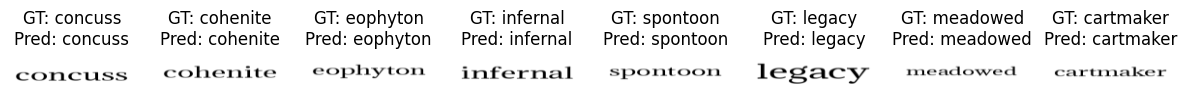

In [10]:
BATCH_SIZE = 8
NUM_EPOCHS = 100



# ---------------------------
# Step 4: Define the Residual Block and CRNN Model
# ---------------------------
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride, skip_conv, dropout=0.2, activation='relu'):
        """
        A residual block with two 3x3 convolutions and an optional skip convolution.
        """
        super(ResidualBlock, self).__init__()
        self.activation = nn.ReLU() if activation == 'relu' else nn.LeakyReLU(0.2)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.skip_conv = skip_conv
        if skip_conv:
            self.conv_skip = nn.Conv2d(in_channels, out_channels, kernel_size=1,
                                       stride=stride, padding=0, bias=False)
            self.bn_skip = nn.BatchNorm2d(out_channels)
        self.dropout = nn.Dropout(dropout) if dropout > 0 else nn.Identity()

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.activation(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.skip_conv:
            identity = self.conv_skip(identity)
            identity = self.bn_skip(identity)
        out += identity
        out = self.activation(out)
        out = self.dropout(out)
        return out

class CRNNResidual(nn.Module):
    def __init__(self, input_shape, output_dim, activation='relu', dropout=0.2):
        """
        CRNN model using residual blocks.
        input_shape: (channels, height, width) e.g. (1, 32, 128)
        output_dim: number of distinct characters (excluding the blank token)
        The model outputs (sequence_length, batch, output_dim+1) logits for CTC loss.
        """
        super(CRNNResidual, self).__init__()
        # Residual blocks as per your Keras model.
        self.block1 = ResidualBlock(in_channels=input_shape[0], out_channels=16,
                                    stride=1, skip_conv=True, dropout=dropout, activation=activation)
        self.block2 = ResidualBlock(in_channels=16, out_channels=16,
                                    stride=2, skip_conv=True, dropout=dropout, activation=activation)
        self.block3 = ResidualBlock(in_channels=16, out_channels=16,
                                    stride=1, skip_conv=False, dropout=dropout, activation=activation)
        self.block4 = ResidualBlock(in_channels=16, out_channels=32,
                                    stride=2, skip_conv=True, dropout=dropout, activation=activation)
        self.block5 = ResidualBlock(in_channels=32, out_channels=32,
                                    stride=1, skip_conv=False, dropout=dropout, activation=activation)
        self.block6 = ResidualBlock(in_channels=32, out_channels=64,
                                    stride=1, skip_conv=True, dropout=dropout, activation=activation)
        self.block7 = ResidualBlock(in_channels=64, out_channels=64,
                                    stride=1, skip_conv=False, dropout=dropout, activation=activation)
        # After block7, assume output shape is (B, 64, H', W').
        # Flatten spatial dimensions: sequence_length = H'*W*, features = 64.
        self.blstm = nn.LSTM(input_size=64, hidden_size=64, num_layers=1,
                             bidirectional=True, batch_first=True)
        self.fc = nn.Linear(64 * 2, output_dim + 1)  # output_dim+1 classes (including blank)

    def forward(self, x):
        # x: (B, 1, 32, 128)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.block6(x)
        x = self.block7(x)
        # x now has shape (B, 64, H', W'). Flatten spatial dims.
        B, C, H, W = x.size()
        x = x.view(B, C, H * W)  # shape: (B, 64, seq_len) where seq_len = H*W
        x = x.permute(0, 2, 1)   # shape: (B, seq_len, 64)
        # Pass through bidirectional LSTM.
        x, _ = self.blstm(x)     # shape: (B, seq_len, 128)
        # Fully connected layer applied at each time step.
        x = self.fc(x)           # shape: (B, seq_len, output_dim+1)
        # For CTC loss, rearrange to (seq_len, B, output_dim+1)
        x = x.permute(1, 0, 2)
        return x

# Instantiate the model.
# Input shape: (channels, height, width) = (1, 32, 128)
model_res = CRNNResidual(input_shape=(1, 32, 128), output_dim=len(vocab), activation='relu', dropout=0.2)
model_res = model_res.to(DEVICE)
print(model_res)

# ---------------------------
# Step 5: Loss Function and Optimizer
# ---------------------------
ctc_loss_fn = nn.CTCLoss(blank=blank_idx, zero_infinity=True)
optimizer_res = optim.Adam(model_res.parameters(), lr=LEARNING_RATE)

# ---------------------------
# Step 6: Training Loop
# ---------------------------
def train_model(model, dataloader, optimizer, criterion, num_epochs, device):
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for images, targets, target_lengths, raw_labels in dataloader:
            images = images.to(device)
            targets = targets.to(device)
            batch_size = images.size(0)
            outputs = model(images)  # outputs shape: (T, batch, num_classes)
            T = outputs.size(0)
            # All samples have T time steps.
            input_lengths = torch.full(size=(batch_size,), fill_value=T, dtype=torch.long).to(device)
            loss = criterion(outputs.log_softmax(2), targets, input_lengths, target_lengths.to(device))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        avg_loss = epoch_loss / len(dataloader)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")
    print("Training complete.")

train_model(model_res, train_loader, optimizer_res, ctc_loss_fn, NUM_EPOCHS, DEVICE)

# ---------------------------
# Step 7: Greedy Decoder for Evaluation
# ---------------------------
def greedy_decoder(output, blank=blank_idx):
    """
    Performs greedy decoding on the network output.
    Args:
      output: Tensor of shape (T, batch, num_classes)
      blank: Index representing the blank token.
    Returns:
      List of decoded strings (one per sample in the batch).
    """
    output = output.permute(1, 0, 2)  # shape: (batch, T, num_classes)
    decoded_texts = []
    for seq in output:
        _, max_indices = torch.max(seq, dim=1)  # shape: (T,)
        prev_idx = blank
        decoded = []
        for idx in max_indices.cpu().numpy().tolist():
            if idx != blank and idx != prev_idx:
                decoded.append(idx)
            prev_idx = idx
        decoded_text = "".join([idx_to_char[i] for i in decoded])
        decoded_texts.append(decoded_text)
    return decoded_texts

# ---------------------------
# Step 8: Additional Evaluation Metrics
# ---------------------------
def levenshtein_distance(s1, s2):
    """
    Compute the Levenshtein (edit) distance between two strings.
    """
    m, n = len(s1), len(s2)
    dp = np.zeros((m+1, n+1), dtype=int)
    for i in range(m+1):
        dp[i][0] = i
    for j in range(n+1):
        dp[0][j] = j
    for i in range(1, m+1):
        for j in range(1, n+1):
            cost = 0 if s1[i-1] == s2[j-1] else 1
            dp[i][j] = min(dp[i-1][j] + 1,      # deletion
                           dp[i][j-1] + 1,      # insertion
                           dp[i-1][j-1] + cost) # substitution
    return dp[m][n]

def evaluate_model(model, dataloader, device):
    model.eval()
    total_samples = 0
    correct_words = 0
    total_edit_distance = 0
    total_chars = 0
    all_decoded = []
    all_ground_truths = []
    
    with torch.no_grad():
        for images, targets, target_lengths, raw_labels in dataloader:
            images = images.to(device)
            outputs = model(images)  # (T, batch, num_classes)
            decoded_texts = greedy_decoder(outputs, blank=blank_idx)
            all_decoded.extend(decoded_texts)
            all_ground_truths.extend(raw_labels)
            for pred, gt in zip(decoded_texts, raw_labels):
                total_samples += 1
                if pred.lower() == gt.lower():
                    correct_words += 1
                distance = levenshtein_distance(pred.lower(), gt.lower())
                total_edit_distance += distance
                total_chars += len(gt)
    word_accuracy = correct_words / total_samples if total_samples > 0 else 0.0
    cer = total_edit_distance / total_chars if total_chars > 0 else 0.0
    print(f"Test Set Word Accuracy: {word_accuracy * 100:.2f}%")
    print(f"Average Levenshtein Distance: {total_edit_distance/total_samples:.2f}")
    print(f"Character Error Rate (CER): {cer * 100:.2f}%")
    return all_decoded, all_ground_truths, word_accuracy, cer

predicted_texts, ground_truth_texts, word_acc, cer = evaluate_model(model_res, test_loader, DEVICE)

print("\nSome example predictions on the test set:")
for gt, pred in zip(ground_truth_texts[:10], predicted_texts[:10]):
    print(f"Ground Truth: {gt}\t Predicted: {pred}")

# ---------------------------
# Step 9: Display Images with Predictions
# ---------------------------
def denormalize_image(tensor_img):
    """
    De-normalize a tensor image (assumed normalized with mean=0.5, std=0.5)
    and convert it to a PIL Image.
    """
    tensor_img = tensor_img * 0.5 + 0.5  # reverse normalization
    np_img = tensor_img.squeeze().cpu().numpy()  # remove channel dimension (C=1)
    np_img = (np_img * 255).astype(np.uint8)
    return Image.fromarray(np_img)

# Display a few examples from the test set with their predictions.
model_res.eval()
with torch.no_grad():
    for images, targets, target_lengths, raw_labels in test_loader:
        images = images.to(DEVICE)
        outputs = model_res(images)  # (T, batch, num_classes)
        decoded_texts = greedy_decoder(outputs, blank=blank_idx)
        pil_images = [denormalize_image(img) for img in images]
        num_examples = len(pil_images)
        plt.figure(figsize=(15, 3 * num_examples))
        for i, (img, gt, pred) in enumerate(zip(pil_images, raw_labels, decoded_texts)):
            plt.subplot(1, num_examples, i+1)
            plt.imshow(img, cmap='gray')
            plt.title(f"GT: {gt}\nPred: {pred}")
            plt.axis("off")
        plt.show()
        break  # Show only the first batch


Train Set Word Accuracy: 100.00%
Average Levenshtein Distance: 0.00
Character Error Rate (CER): 0.00%

Some example predictions on the train set:
Ground Truth: chrysopa	 Predicted: chrysopa
Ground Truth: subduct	 Predicted: subduct
Ground Truth: souffleed	 Predicted: souffleed
Ground Truth: aulicism	 Predicted: aulicism
Ground Truth: unhating	 Predicted: unhating
Ground Truth: factice	 Predicted: factice
Ground Truth: defeature	 Predicted: defeature
Ground Truth: areolate	 Predicted: areolate
Ground Truth: chrysenic	 Predicted: chrysenic
Ground Truth: whorl	 Predicted: whorl


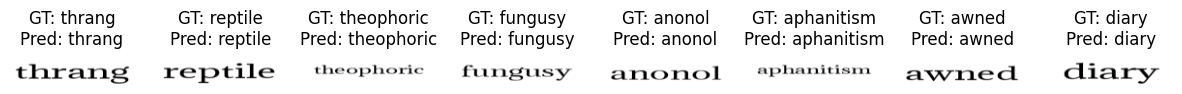

In [11]:
def evaluate_model(model, dataloader, device):
    model.eval()
    total_samples = 0
    correct_words = 0
    total_edit_distance = 0
    total_chars = 0
    all_decoded = []
    all_ground_truths = []
    
    with torch.no_grad():
        for images, targets, target_lengths, raw_labels in dataloader:
            images = images.to(device)
            outputs = model(images)  # (T, batch, num_classes)
            decoded_texts = greedy_decoder(outputs, blank=blank_idx)
            all_decoded.extend(decoded_texts)
            all_ground_truths.extend(raw_labels)
            for pred, gt in zip(decoded_texts, raw_labels):
                total_samples += 1
                if pred.lower() == gt.lower():
                    correct_words += 1
                distance = levenshtein_distance(pred.lower(), gt.lower())
                total_edit_distance += distance
                total_chars += len(gt)
    word_accuracy = correct_words / total_samples if total_samples > 0 else 0.0
    cer = total_edit_distance / total_chars if total_chars > 0 else 0.0
    print(f"Train Set Word Accuracy: {word_accuracy * 100:.2f}%")
    print(f"Average Levenshtein Distance: {total_edit_distance/total_samples:.2f}")
    print(f"Character Error Rate (CER): {cer * 100:.2f}%")
    return all_decoded, all_ground_truths, word_accuracy, cer

predicted_texts, ground_truth_texts, word_acc, cer = evaluate_model(model_res, train_loader, DEVICE)

print("\nSome example predictions on the train set:")
for gt, pred in zip(ground_truth_texts[:10], predicted_texts[:10]):
    print(f"Ground Truth: {gt}\t Predicted: {pred}")

# ---------------------------
# Step 9: Display Images with Predictions
# ---------------------------
def denormalize_image(tensor_img):
    """
    De-normalize a tensor image (assumed normalized with mean=0.5, std=0.5)
    and convert to a PIL Image.
    """
    tensor_img = tensor_img * 0.5 + 0.5  # reverse normalization
    np_img = tensor_img.squeeze().cpu().numpy()  # remove channel dimension (C=1)
    np_img = (np_img * 255).astype(np.uint8)
    return Image.fromarray(np_img)

# Show one batch from the test set with images and predictions.
model_res.eval()
with torch.no_grad():
    for images, targets, target_lengths, raw_labels in train_loader:
        images = images.to(DEVICE)
        outputs = model_res(images)  # (T, batch, num_classes)
        decoded_texts = greedy_decoder(outputs, blank=blank_idx)
        pil_images = [denormalize_image(img) for img in images]
        num_examples = len(pil_images)
        plt.figure(figsize=(15, 3 * num_examples))
        for i, (img, gt, pred) in enumerate(zip(pil_images, raw_labels, decoded_texts)):
            plt.subplot(1, num_examples, i+1)
            plt.imshow(img, cmap='gray')
            plt.title(f"GT: {gt}\nPred: {pred}")
            plt.axis("off")
        plt.show()
        break  # display only the first batch


In [13]:
torch.save(model_res, "model_task2_e.pth")